In [1]:
import pandas as pd
import numpy as np
import pickle

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, adjusted_rand_score, silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans, DBSCAN

# Visualization
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
data = pd.read_csv('test_ML2.csv')
data.shape

(28346, 24)

In [9]:
# Drop rows without target
data.dropna(subset='target', axis=0, inplace=True)
data.shape

(28346, 24)

In [10]:
y = data['target']
X = data.drop(['symbol', 'EnterpriseValue', 'target'], axis=1) # Quid de garder l'EV actuelle ?

In [11]:
X.columns

Index(['date', 'TotalRevenue', 'RevenueGrowth', 'GrossMargin', 'EBITDAMargin',
       'EBITMargin', 'PretaxIncomeMargin', 'NetIncomeMargin', 'Leverage',
       'PercentageCapitalExpenditureRevenue', 'ReturnOnEquity',
       'ReturnOnAssets', 'FreeCashFlowMargin', 'ConversionEBITDAFreeCashFlow',
       'ConversionNetIncomeFreeCashFlow', 'ConversionEBITDACash',
       'ConversionNetIncomeCash', 'sector', 'industry', 'country',
       'fullTimeEmployees'],
      dtype='object')

In [12]:
categorical_cols = list(X.columns[X.dtypes == 'object'])
numerical_cols = list(X.columns[X.dtypes != 'object'])

In [13]:
# Definition of preprocessing steps

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('stdscaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [14]:
X_prep = preprocessor.fit_transform(X)

c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

# Regression

In [15]:
model = RandomForestRegressor(random_state=0)
model.fit(X_prep, y)

c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


RandomForestRegressor(random_state=0)

In [16]:
predictions = model.predict(X_prep)

Explore results

In [17]:
compare = pd.DataFrame(data=y)
compare['symbol'] = data['symbol']
compare['predictions_initiales'] = predictions
compare['absolute_differencial'] = compare['target'] - compare['predictions_initiales']
compare['relative_differencial'] = compare['absolute_differencial'] / compare['target']

In [18]:
compare[compare['relative_differencial'] > 0.05]

,target,symbol,predictions_initiales,absolute_differencial,relative_differencial
21448,-1.259188e+10,BNP.PA,-1.172511e+10,-8.667694e+08,0.068836
21455,4.379517e+08,BNP.PA,-4.817459e+07,4.861263e+08,1.110000
21456,2.311523e+09,BNP.PA,1.563336e+09,7.481869e+08,0.323677


In [19]:
compare[compare['relative_differencial'] < -0.05]

,target,symbol,predictions_initiales,absolute_differencial,relative_differencial
21444,-1.654057e+10,BNP.PA,-1.828776e+10,1.747186e+09,-0.105630
21449,-7.290874e+09,BNP.PA,-8.445906e+09,1.155031e+09,-0.158422
21450,-5.430631e+09,BNP.PA,-5.956443e+09,5.258123e+08,-0.096823
21451,-3.560337e+09,BNP.PA,-4.222288e+09,6.619512e+08,-0.185924
21454,-1.417881e+09,BNP.PA,-1.769639e+09,3.517587e+08,-0.248088
26271,-9.039046e+09,GLE.PA,-9.862624e+09,8.235785e+08,-0.091113
26469,-1.517658e+10,GLE.PA,-1.633798e+10,1.161402e+09,-0.076526


In [20]:
r2 = r2_score(y, predictions)
MSE = mean_squared_error(y, predictions)
RMSE = mean_squared_error(y, predictions, squared=False)
MAE = mean_absolute_error(y, predictions)

c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseD

In [21]:
print("r2 : {}".format(r2))
print("MSE : {}".format(MSE))
print("RMSE : {}".format(RMSE))
print("MAE : {}".format(MAE))

r2 : 0.9999993578649481
MSE : 6704950932163720.0
RMSE : 81883764.76545103
MAE : 30888042.54815737


c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


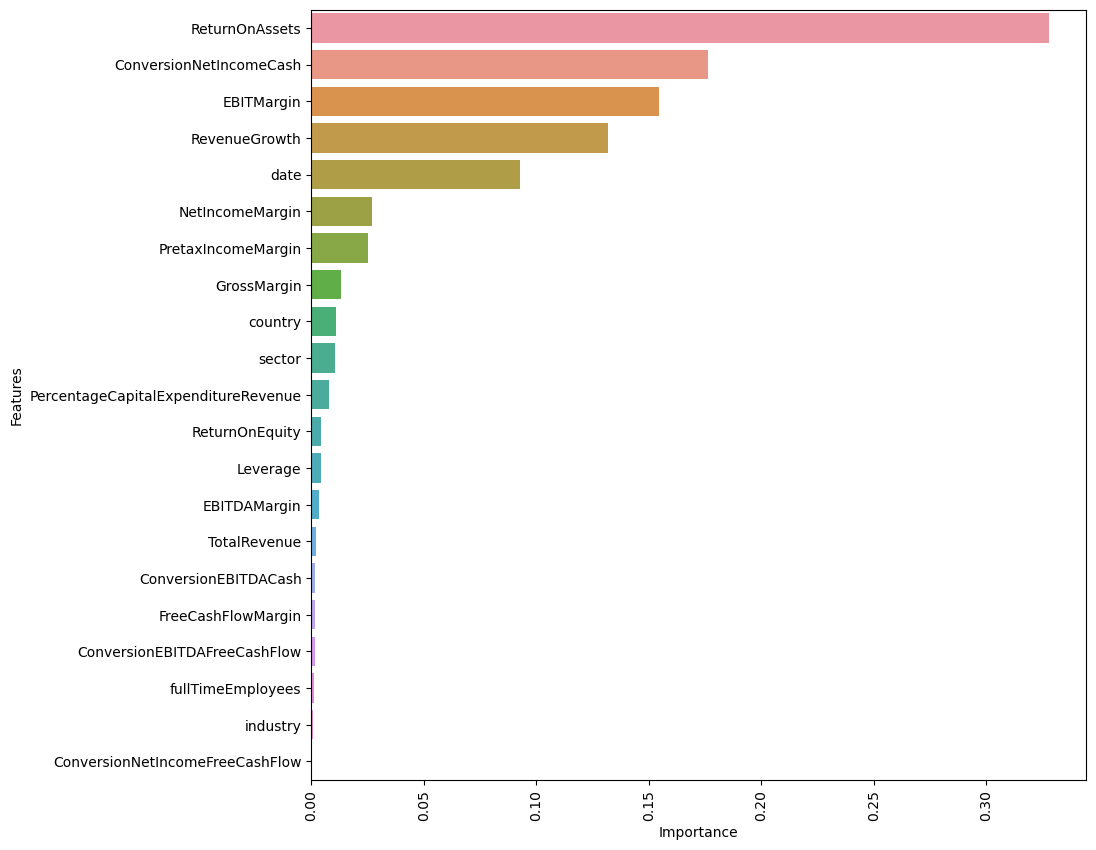

In [22]:
# Plot feature importance
feature_list = list(X.columns)

feat_importance = model.feature_importances_

feat_df = pd.DataFrame({'Features' : feature_list, 'Importance' : feat_importance})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(data=feat_df, x='Importance', y='Features')
plt.xticks(rotation=90)
plt.show()

In [23]:
# Save model and preprocessor

pickle.dump(preprocessor, open('./test_preprocessor_2.pkl', 'wb'))
pickle.dump(model, open('./test_model_2.pkl', 'wb'))

# Clustering

In [24]:
def test_KMeans(k_clusters:range, X):
    """Function which tests values in k_clusters for a KMeans (KMeans++ with one iteration) and displays inertia, 
    davies bouldin and silhouettes scores. X must be processed"""
    
    inertia_scores = []
    silhouette_scores = []
    davies_bouldin_scores = []
    
    for k in k_clusters:
    
        model = KMeans(n_clusters=k, random_state=0)
        model.fit(X)

        inertia_scores.append(-model.score(X))
        silhouette_scores.append(silhouette_score(X, model.labels_))
        davies_bouldin_scores.append(davies_bouldin_score(X, model.labels_))
        
    
    plt.figure(figsize=(19,5))
    
    plt.subplot(1,3,1)
    plt.plot(k_clusters, inertia_scores)
    plt.xlabel('number of clusters')
    plt.title('inertia score')
    
    plt.subplot(1,3,2)
    plt.plot(k_clusters, silhouette_scores)
    plt.xlabel('number of clusters')
    plt.title('silhouette score')
    
    plt.subplot(1,3,3)
    plt.plot(k_clusters, davies_bouldin_scores)
    plt.xlabel('number of clusters')
    plt.title('davies bouldin score')

    return pd.DataFrame({'K' : [i for i in k_clusters], 'inertia_scores' : inertia_scores, 
                         'silhouette_scores' : silhouette_scores, 'davies_bouldin_scores' : davies_bouldin_scores})

c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

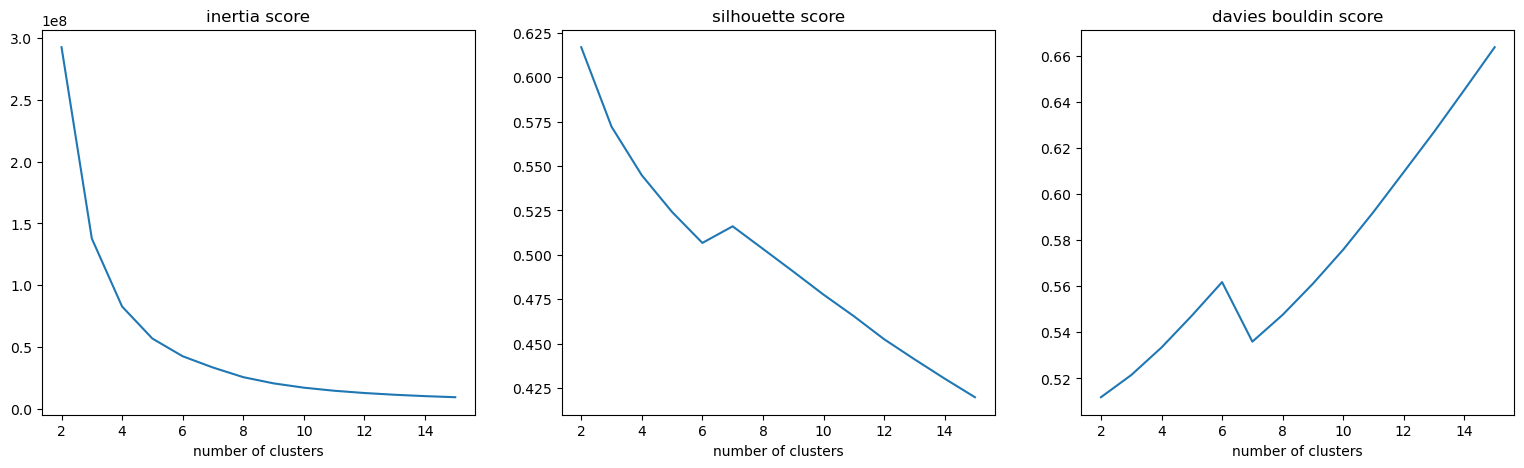

In [25]:
simplified_KMeans = test_KMeans(range(2,16), X_prep)

In [26]:
KMeans_model = KMeans(n_clusters=6, random_state=0)
KMeans_model.fit(X_prep)

c:\Users\robin\anaconda3\envs\time_series\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=0)

In [27]:
KMeans_model.labels_

array([3, 3, 3, ..., 0, 0, 0])

In [28]:
pickle.dump(KMeans_model, open('./test_clustering_2.pkl', 'wb'))